In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import math
import seaborn as sns
from math import log10, floor
%matplotlib inline

In [2]:
#change the size of the visualisations to make them big and more readable
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 14
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15

In [3]:
#display share prices in float format rather than scientific notation
pd.set_option('display.float_format', lambda x: '%.4f' % x)
#pd.set_option('display.float_format', lambda x: round(x, 2-int(floor(log10(abs(x))))-1))

In [4]:
#function to convert json file to dataframe 
def convert_to_df(json):
    #convert json file to dataframe object
    df = pd.read_json(json)
    
    #create empty lists to be populated iteratively
    utc_time = []
    high = []
    low = []
    opn = []
    close = []
    #populate lists iteratively
    for i in range(len(df['Data']['Data'])):
        utc_time.append(df['Data']['Data'][i]['time'])
        high.append(df['Data']['Data'][i]['high'])
        low.append(df['Data']['Data'][i]['low'])
        opn.append(df['Data']['Data'][i]['open'])
        close.append(df['Data']['Data'][i]['close'])
    
    #create refined dataframe from these lists
    df = pd.DataFrame()
    df['time'] = utc_time
    df['high'] = high
    df['low'] = low
    df['open'] = opn
    df['close'] = close
    
    #convert time column from Epoch to YYYY-MM-DD
    df['time'] = pd.to_datetime(df['time'], unit='s')
    
    #set the index to time
    df = df.set_index('time')
    
    #return the dataframe
    return df

In [5]:
#function to create overall dataframes of all currencies for a given price type (high, low, open, close)
#and sort the columns in descending order of the highest value in each column
def create_overall(col, currencies):
    overall = pd.concat(col, axis = 1, join = 'inner')
    overall.columns = currencies
    
    #sort columns in dataframe in descending order of the highest value in each column
    overall = overall.loc[:, overall.max().sort_values(ascending=False).index]
    
    return overall

In [6]:
#list of currencies
currencies = ['BTC','ETH','XRP','BCH','ADA','LTC','XEM','XLM','EOS','NEO','MIOTA','DASH','XMR','TRX','XTZ','DOGE','ETC','VEN','USDT','BNB']

#create lists to store data for all currencies
high_cols = []
low_cols = []
open_cols = []
close_cols = []

#iteratively create dataframes for each cryptocurrency
for currency in currencies:
    #assign the name of the df (e.g. BTC_df) as a string to the df_name variable
    df_name = currency+'_df'
    #concatenate '.json' to the end of the currency so the json file can be read
    currency+='.json'
    #use vars to assign the dataframe to the name of the dataframe
    vars()[df_name] = convert_to_df(currency)
    #append each column to overall lists
    high_cols.append(vars()[df_name].high)
    low_cols.append(vars()[df_name].low)
    open_cols.append(vars()[df_name].open)
    close_cols.append(vars()[df_name].close)

#create overall dataframes for the high, low, open and close prices of all currencies
#and sort the columns in descending order of the highest value in each column
overall_high = create_overall(high_cols, currencies)
overall_low = create_overall(low_cols, currencies)
overall_open = create_overall(open_cols, currencies)
overall_close = create_overall(close_cols, currencies)

In [7]:
#function to create a scatter plot with a line of best fit
def scatter(independent, dependent, marker, y_label, title):
    #create scatter plot for the dependent variable versus the independent variable
    plt.scatter(independent, dependent, color = 'red', marker = marker)
    #create the line of best fit using the equation of a line (y = mx + c) by finding the slope and the y-intercept using
    #the numpy.polyfit() function
    m, c = np.polyfit(independent, dependent, 1)
    #plot the line of best fit
    plt.plot(independent, m*independent + c, color = 'lime')
    
    #label x and y axes
    plt.ylabel(y_label)
    
    #first argument for matplotlib.pyplot.legend needs to be iterable so simply
    #assign the correlation coefficient to the first and only element of a list
    corr_coef = [round(independent.corr(dependent), 2-int(floor(log10(abs(independent.corr(dependent)))))-1)]
    #r_squared = round(r2_score(independent, dependent), 2-int(floor(log10(abs(r2_score(independent, dependent))))))
    r_squared = round(corr_coef[0]**2, 2-int(floor(log10(abs(corr_coef[0]**2))))-1)
    corr_coef.append(r_squared)
    
    #display the correlation coefficient on the legend, setting the handlelength to
    #0 so that the marker does not show in the legend
    plt.legend(corr_coef, title="Correlation Coefficient and R Squared", handlelength=0)
    for item in plt.legend(corr_coef, title="Correlation Coefficient and R Squared", handlelength=0).legendHandles:
        item.set_visible(False)
    
    #show the title
    plt.title(title)
    
    plt.show

In [8]:
#function to create small multiples for scatter plots
def plot_scatter_small_multiples(independent, df, num_cols, y_labels, title):
    #number of rows based on num_cols and total rows
    num_rows = ((len(df.columns) - 1)//num_cols)+1
    
    #create grid
    fig, axs = plt.subplots(figsize=(20, 40), ncols=num_cols, nrows=num_rows, sharex=True)
    
    #plot the scatter plots
    cell = 0
    for dependent in df.columns:
        if not independent.equals(df[dependent]):
            cell+=1
            plt.subplot(num_rows, num_cols, cell)
            
            #plot the scatter plot
            scatter(independent, df[dependent], '.', f'{dependent} {y_labels}',
                   f'Relationship between {independent.name} and {dependent}')
    
    #make any unused cells invisible
    unused = (num_cols*num_rows) - len(df.columns) + 1
    if unused > 0:
        for ax in axs.flatten()[-unused:]:
            ax.axis('off')
    
    #add title
    plt.suptitle(title, fontsize=20, y=0.9)
    
    plt.show()

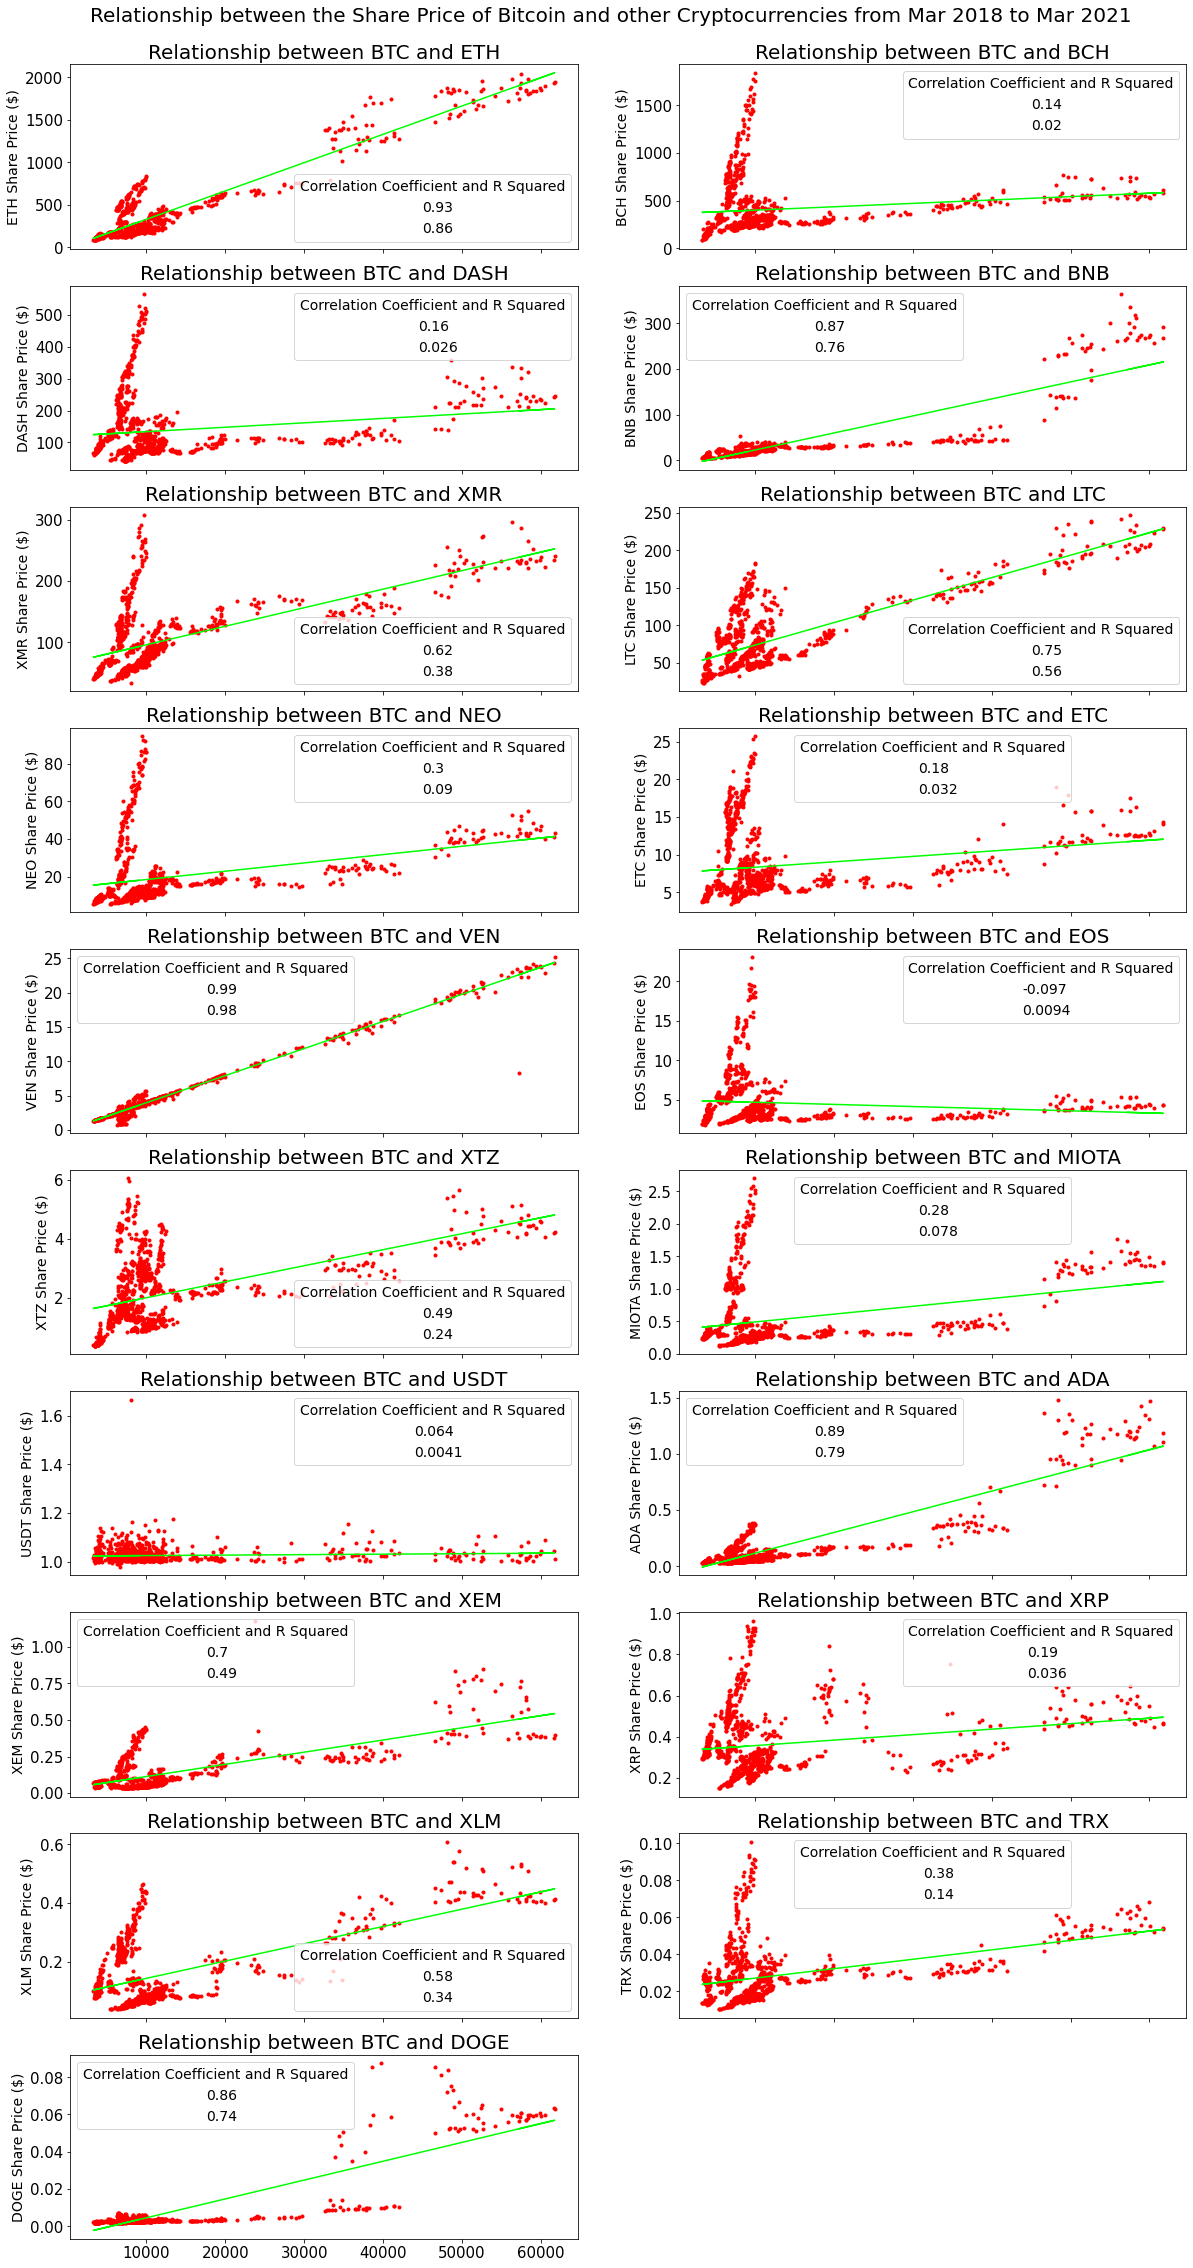

In [9]:
#create small multiples for scatter plots representing the relationship between
#the high share prices of BTC and the high share prices of other cryptocurrencies
#between the years 2018 and 2021
plot_scatter_small_multiples(overall_high['BTC'], overall_high, 2, 'Share Price ($)',
    'Relationship between the Share Price of Bitcoin and other Cryptocurrencies from Mar 2018 to Mar 2021')

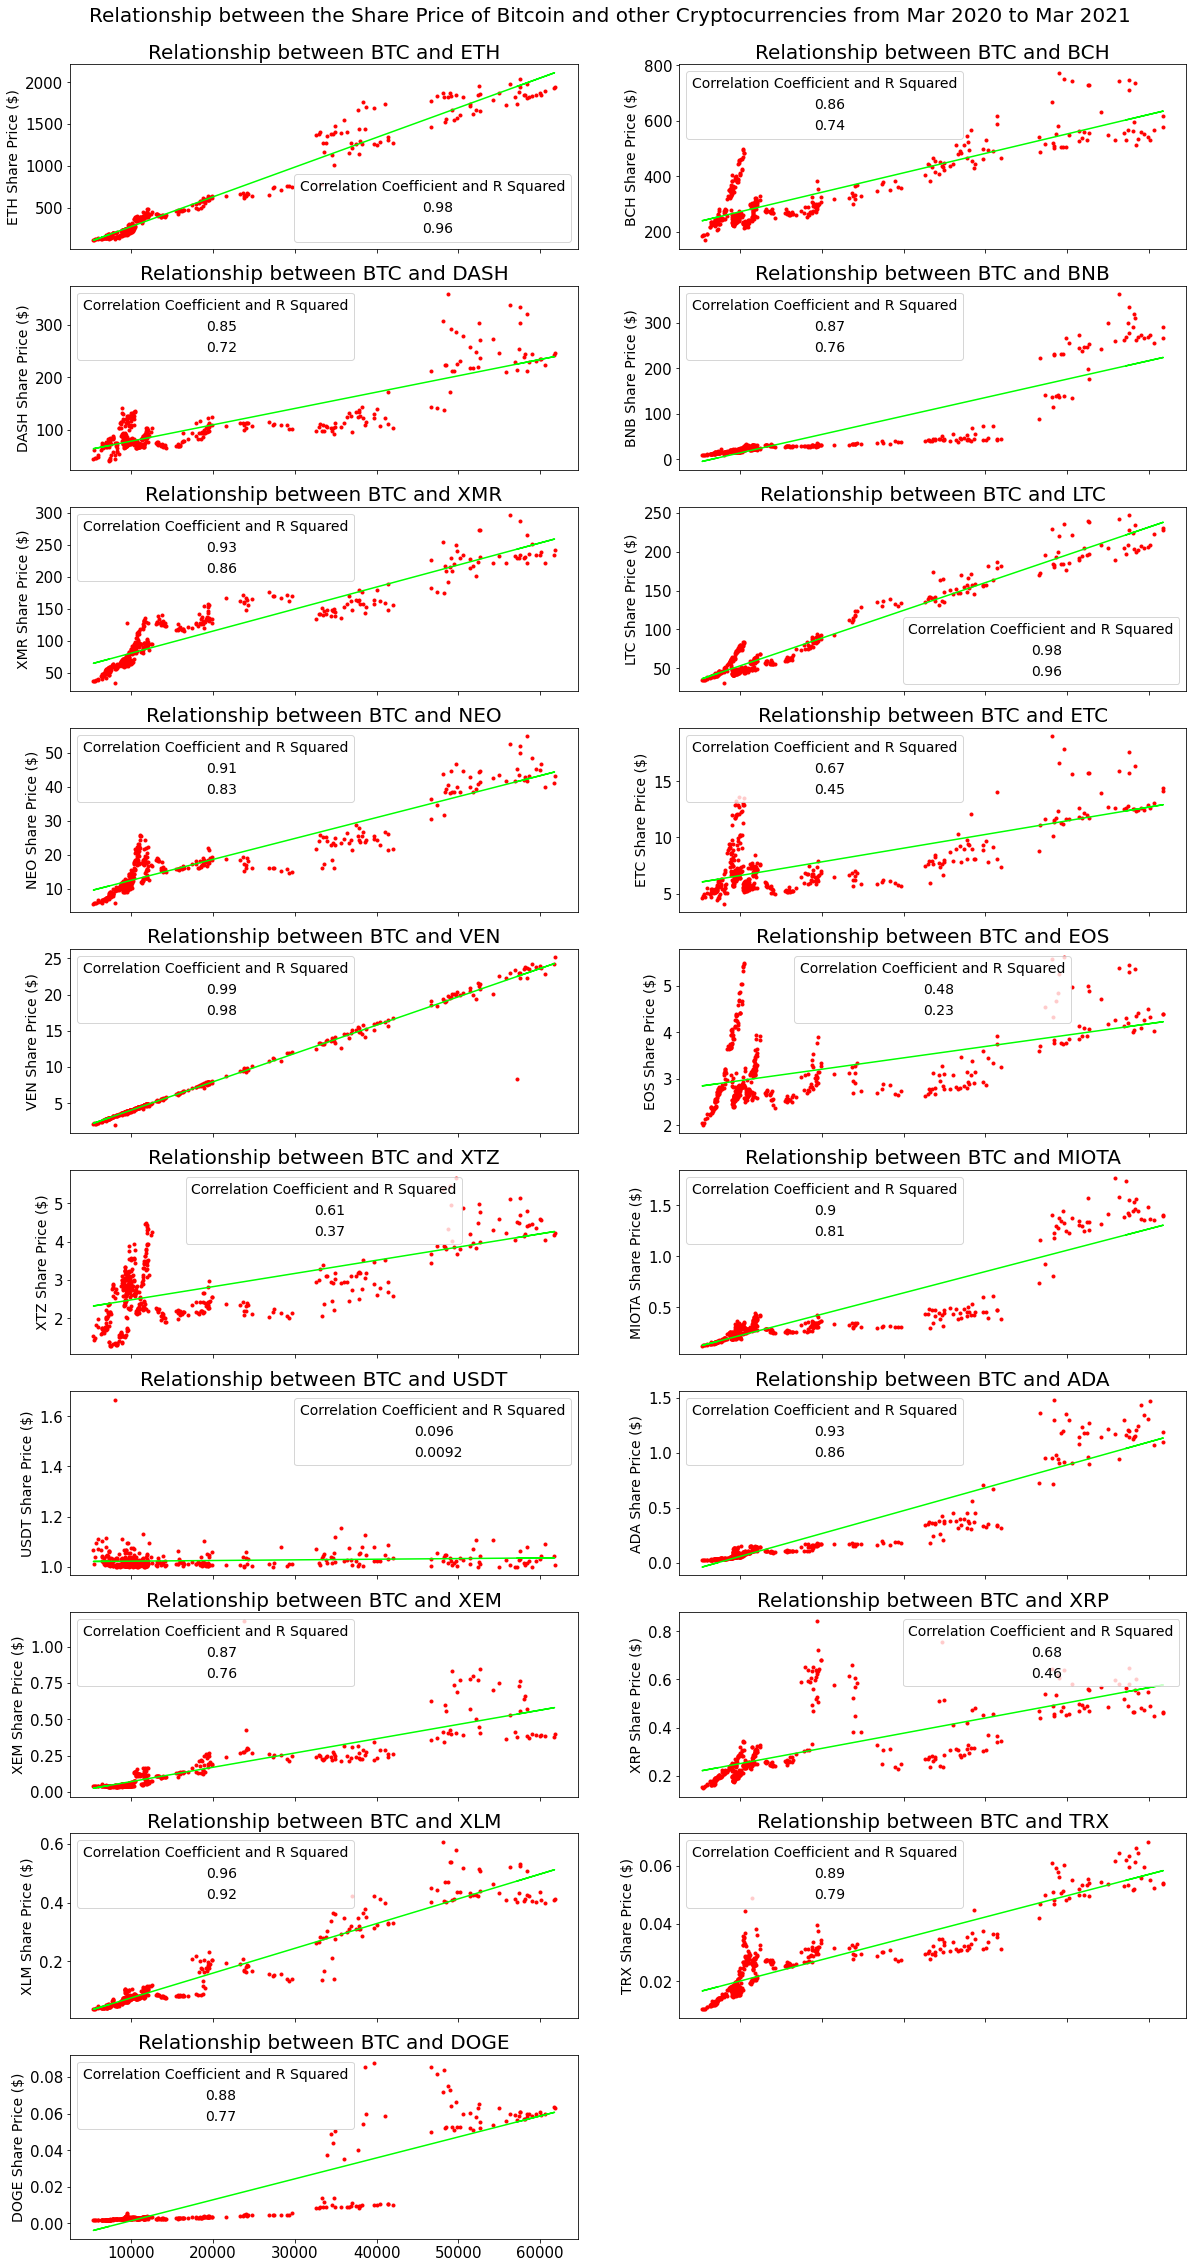

In [10]:
#create small multiples for scatter plots representing the relationship between
#the high share prices of BTC and the high share prices of other cryptocurrencies
#between the years 2020 and 2021
plot_scatter_small_multiples(overall_high.loc['2020':'2021']['BTC'], overall_high.loc['2020':'2021'], 2, 'Share Price ($)',
    'Relationship between the Share Price of Bitcoin and other Cryptocurrencies from Mar 2020 to Mar 2021')

In [11]:
#function to create dataframe with percentage changes as values
def to_pct_change(df):
    pct_change = df.pct_change()
    return pct_change.dropna()

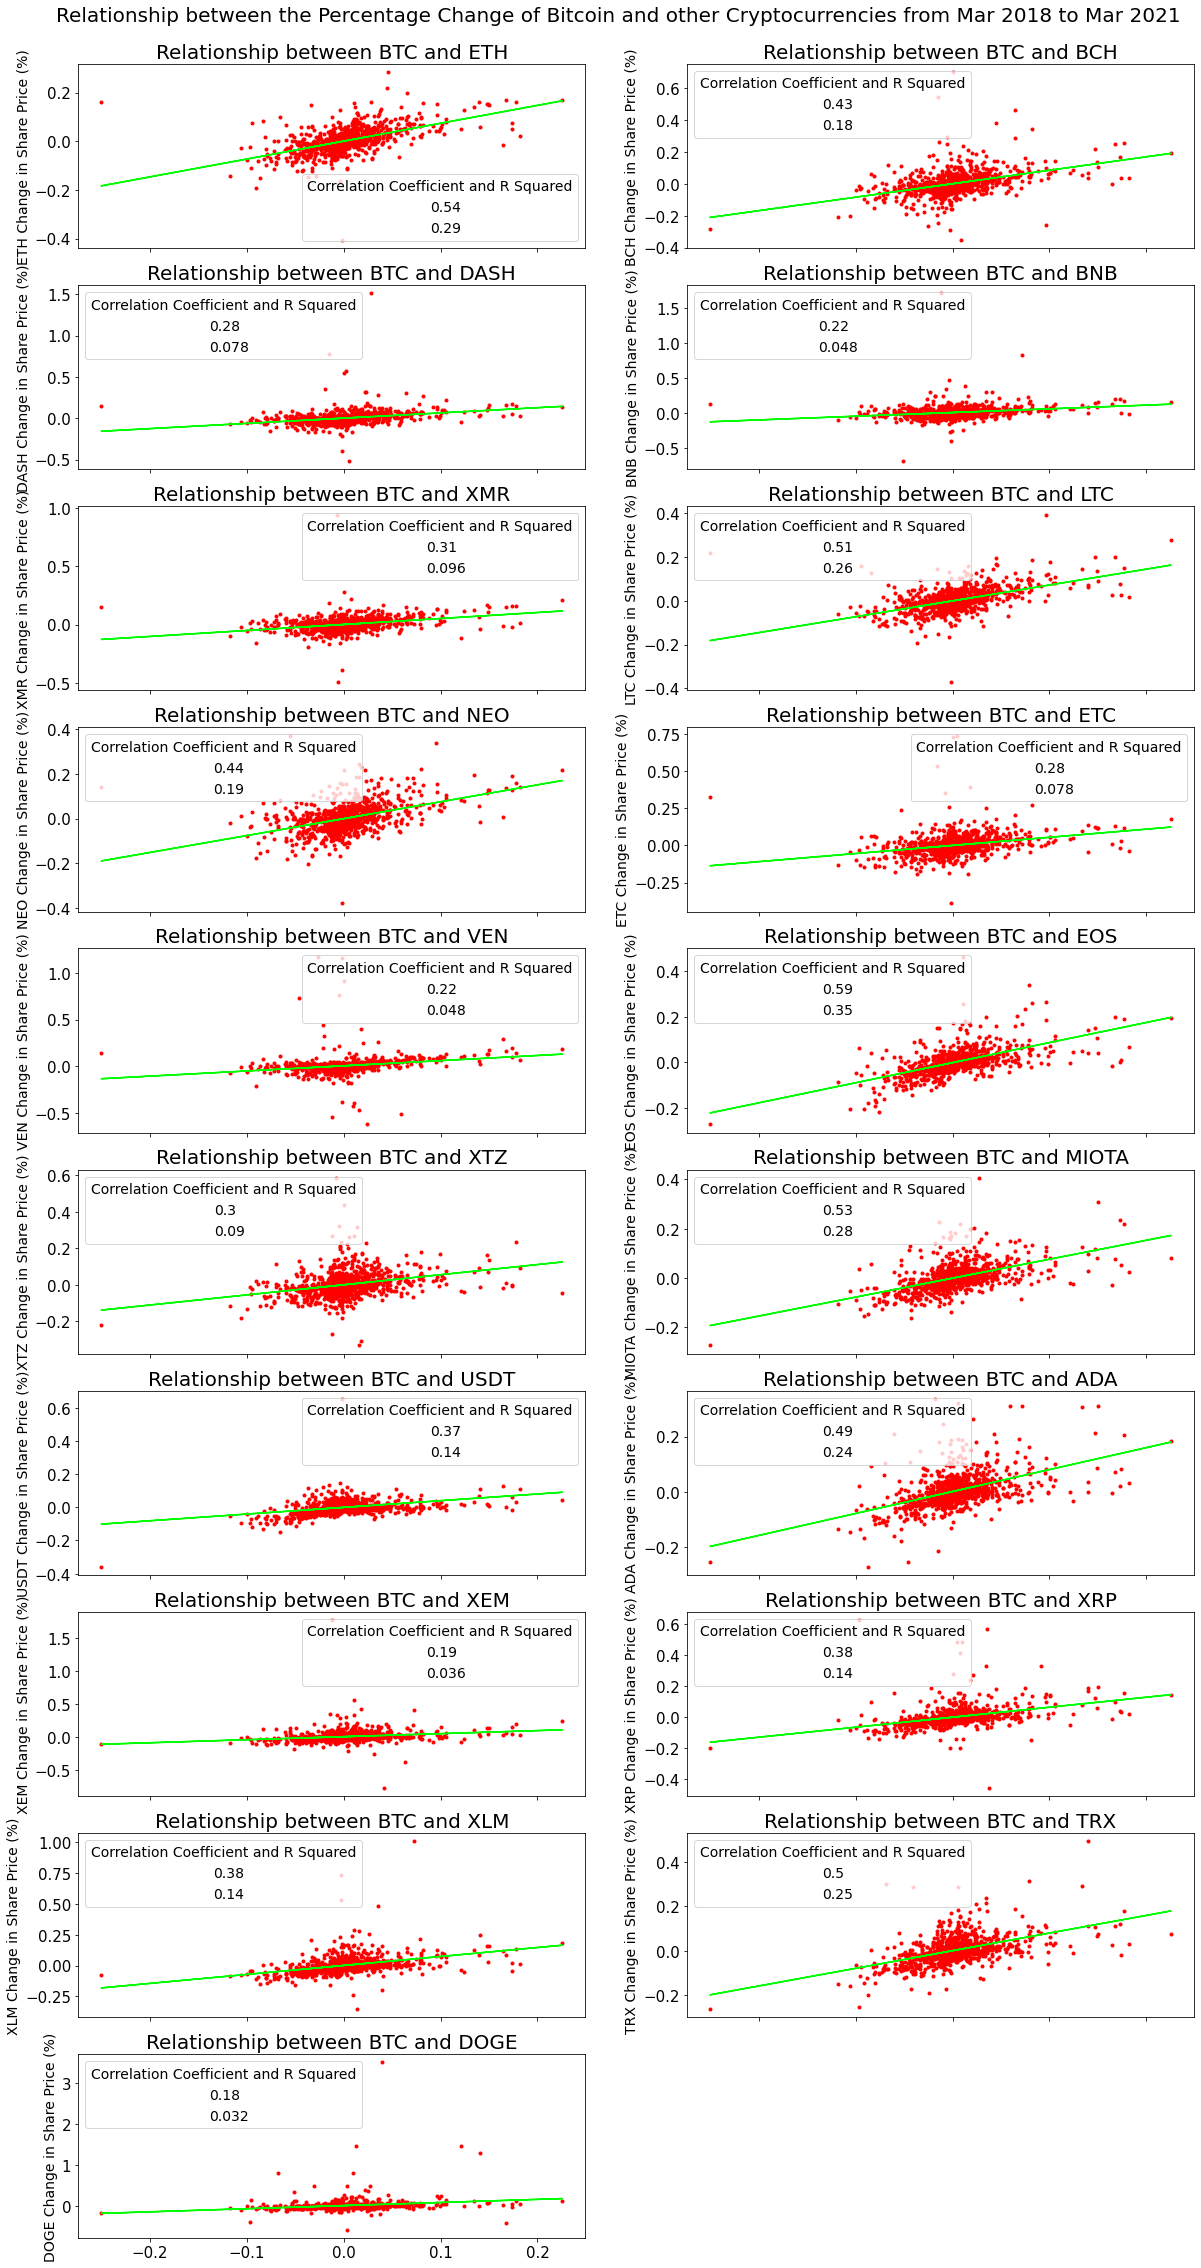

In [12]:
#create small multiples for scatter plots representing the relationship between
#the percentage changes of the high share prices of BTC and the high share prices 
#of other cryptocurrencies between the years 2018 and 2021
plot_scatter_small_multiples(to_pct_change(overall_high)['BTC'], to_pct_change(overall_high), 2,
    'Change in Share Price (%)',
    'Relationship between the Percentage Change of Bitcoin and other Cryptocurrencies from Mar 2018 to Mar 2021')

In [13]:
#function to create dataframe of one currency and the rest of the currencies
#a number of days later
def days_later(df, influencer, days):
    #create a series by dropping the last n days from the series
    #and reset the index to make concatenation less complicated
    influencer_ser = df[influencer].iloc[:-days].reset_index()
    #create a dataframe by dropping the first n days from the dataframe
    #and remove the index to make concatenation less complicated
    influenced = df.iloc[days:].reset_index(drop=True)
    #concatenate the series and the dataframe and set the index to 'time'
    final_df = pd.concat([influencer_ser, influenced], axis=1).set_index('time')
    #change the name of the column that has the same name as the influencer
    cols = []
    cols.extend(currencies)
    for col in range(len(cols)):
        if cols[col] == influencer:
            cols[col] += ' '
    col = [influencer]
    col.extend(cols)
    final_df.columns = col
    return final_df

In [14]:
days_later(overall_high, 'BTC', 1).head()

,BTC,BTC,ETH,XRP,BCH,ADA,LTC,XEM,XLM,EOS,...,MIOTA,DASH,XMR,TRX,XTZ,DOGE,ETC,VEN,USDT,BNB
time,,,,,,,,,,,,,,,,,,,,,
2018-03-24,9036.2300,8690.3600,535.7700,978.6100,418.7300,14.1300,215.6800,163.2200,66.3400,18.3500,...,6.6700,4.1500,1.3700,1.0270,0.1888,0.3213,0.6541,0.2431,0.0499,0.0036
2018-03-25,8690.3600,8521.0400,526.2000,939.1300,397.9900,12.5100,203.8100,160.9600,66.1600,18.0900,...,6.5100,4.0030,1.3300,1.0480,0.1841,0.2998,0.6377,0.2453,0.0464,0.0035
2018-03-26,8521.0400,8226.2400,491.9200,903.4400,373.4800,11.7600,189.6700,149.3300,61.5400,17.2000,...,6.5200,3.5610,1.2400,1.0560,0.1669,0.2760,0.6018,0.2294,0.0477,0.0034
2018-03-27,8226.2400,8117.7900,465.2000,902.6400,362.0900,12.1400,201.1400,139.7900,59.1000,16.5200,...,6.5000,3.2400,1.2500,1.0220,0.1622,0.2643,0.5886,0.2260,0.0496,0.0033
2018-03-28,8117.7900,7983.7700,448.5000,869.2900,337.3500,10.5300,179.8000,132.5200,57.3300,14.8600,...,6.2900,3.1700,1.1900,1.1200,0.1599,0.2595,0.5745,0.2203,0.0540,0.0032


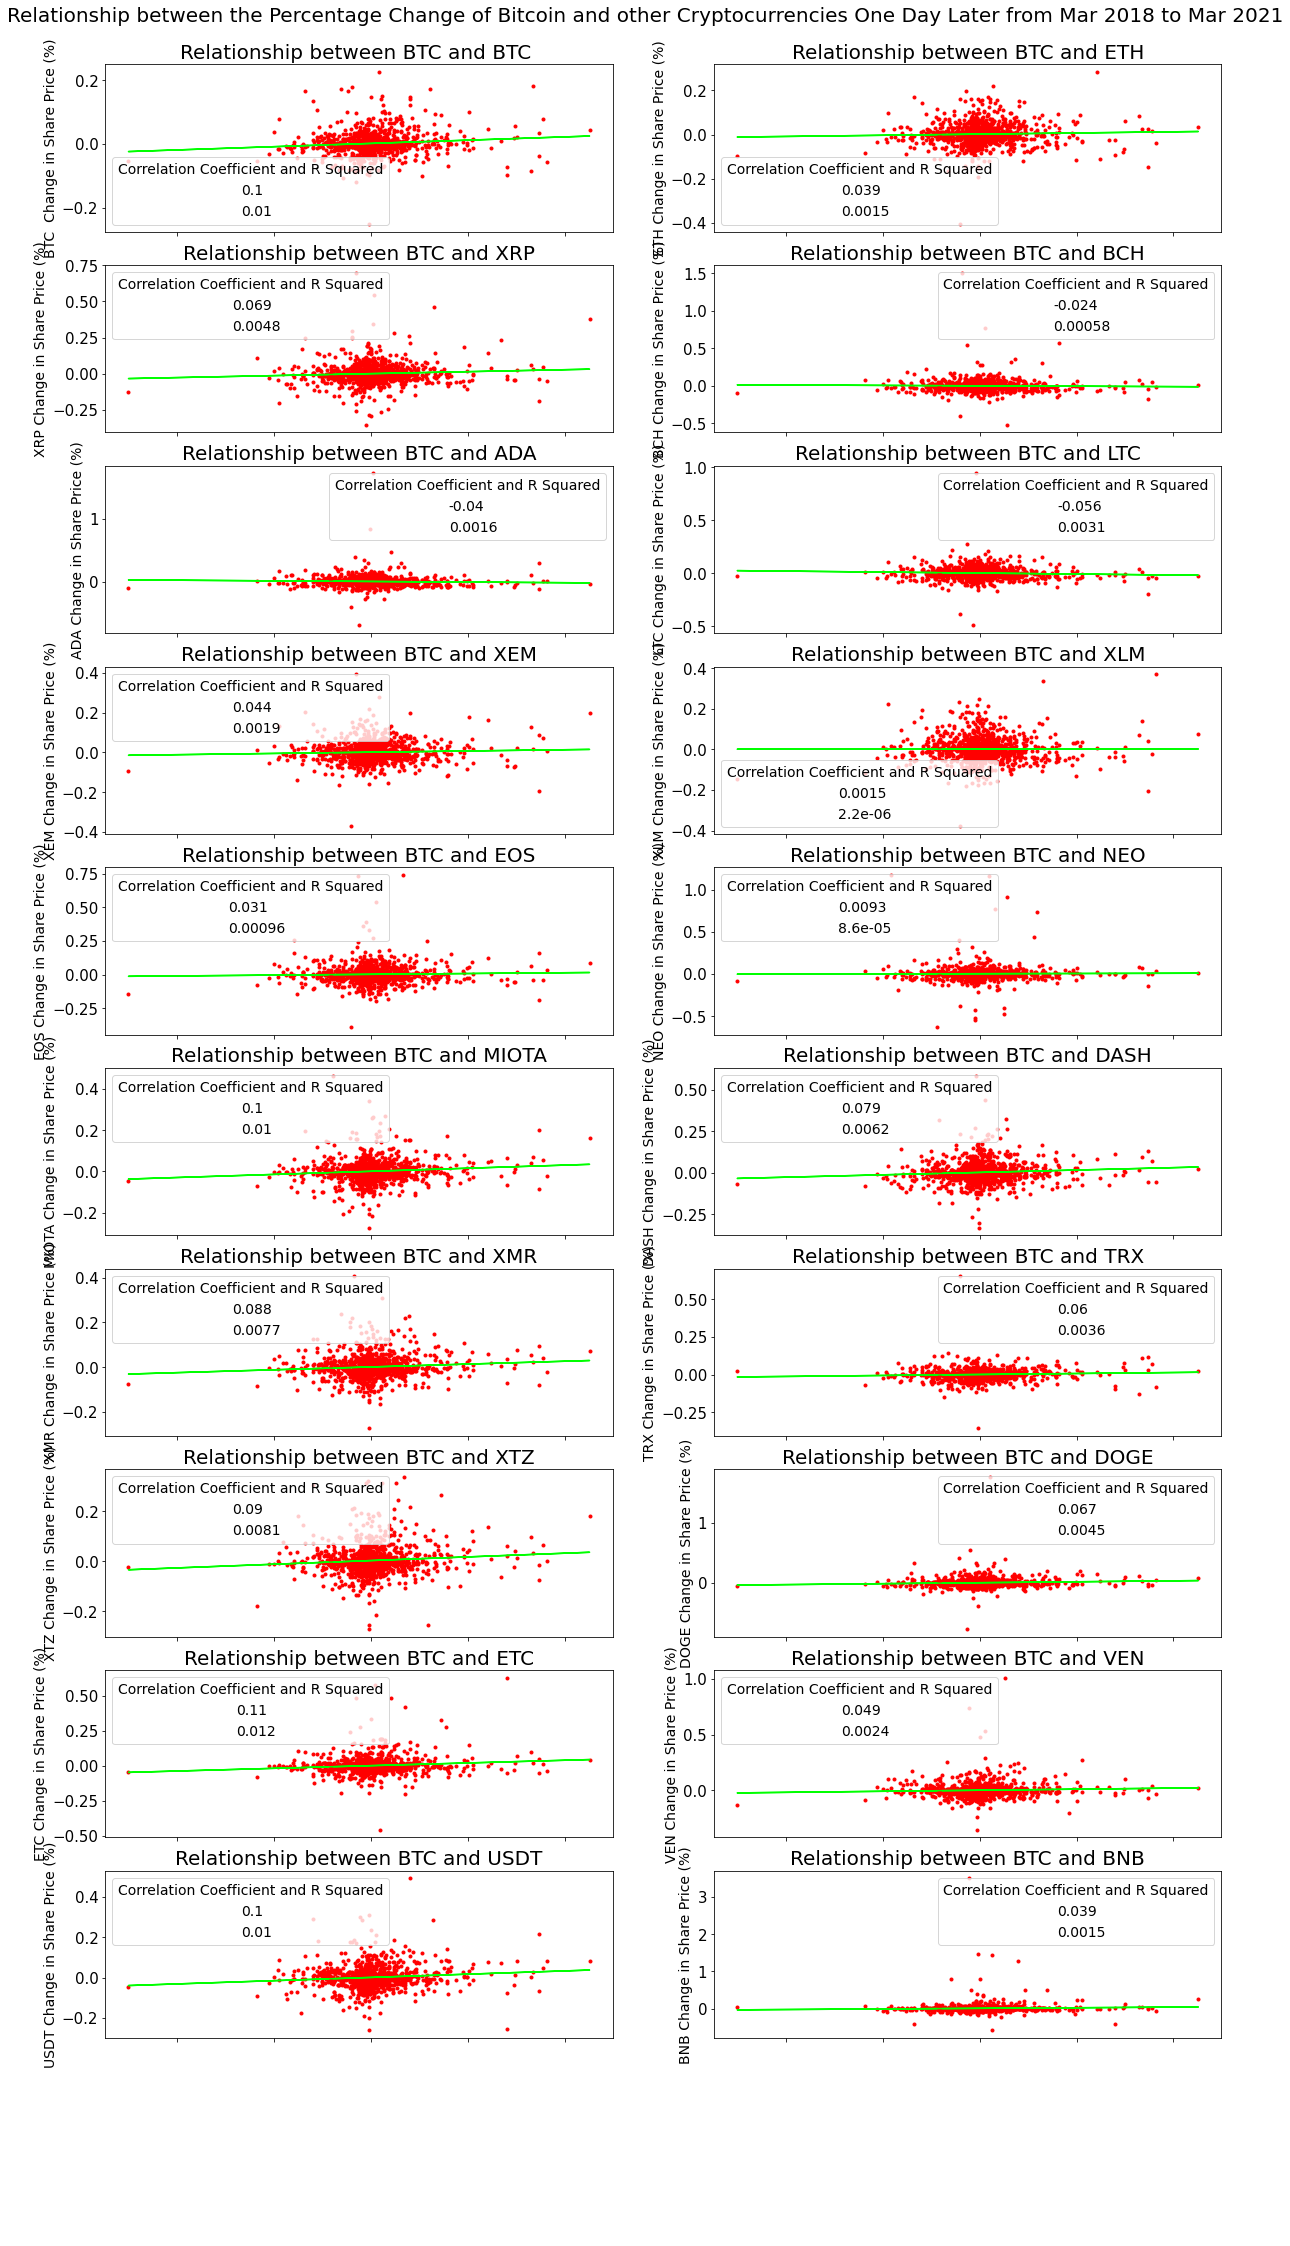

In [15]:
#create small multiples for scatter plots representing the relationship between
#the percentage changes of the high share prices of BTC and the high share prices 
#of other cryptocurrencies between the years 2018 and 2021
plot_scatter_small_multiples(to_pct_change(days_later(overall_high, 'BTC', 1))['BTC'], 
    to_pct_change(days_later(overall_high, 'BTC', 1)), 2,
    'Change in Share Price (%)',
    'Relationship between the Percentage Change of Bitcoin and other Cryptocurrencies One Day Later from Mar 2018 to Mar 2021')

In [16]:
#create interactive scatter plot
def scatter_interactive(df, independent, dependent, start_year, start_month, end_year, end_month, pct_change):
    #concatenate year and month strings to form dates in YYYY-MM format
    start_date = start_year+'-'+start_month
    end_date = end_year+'-'+end_month
    #fail cases
    if start_date > end_date:
        return 'start_date cannot be later than end_date'
    if start_date not in eval(df).index or end_date not in eval(df).index:
        return 'date not available in dataframe'
    
    if pct_change:
        scatter(to_pct_change(eval(df))[independent].loc[start_date:end_date], to_pct_change(eval(df))[dependent].loc[start_date:end_date], 
            '.', f'{dependent} Change in Share Price (%)', 
                f'Relationship between Change in Share Price of {independent} and {dependent}')
    else:
        scatter(eval(df)[independent].loc[start_date:end_date], eval(df)[dependent].loc[start_date:end_date], 
            '.', f'{dependent} Share Price ($)', 
            f'Relationship between Share Price of {independent} and {dependent}')

In [17]:
interact(scatter_interactive, df = ['overall_high', 'overall_low', 'overall_open', 'overall_close'], 
         independent = currencies, dependent = currencies, start_year = ['2018', '2019', '2020', '2021'], 
         start_month = [str(month) for month in range(1, 13)], end_year = ['2018', '2019', '2020', '2021'], 
         end_month = [str(month) for month in range(1, 13)], pct_change = False)

interactive(children=(Dropdown(description='df', options=('overall_high', 'overall_low', 'overall_open', 'over…

<function __main__.scatter_interactive(df, independent, dependent, start_year, start_month, end_year, end_month, pct_change)>

In [18]:
#create interactive scatter plot with number of days later
def scatter_interactive_days_later(df, independent, dependent, start_year, start_month, end_year, end_month, num_days, pct_change):
    #concatenate year and month strings to form dates in YYYY-MM format
    start_date = start_year+'-'+start_month
    end_date = end_year+'-'+end_month
    #fail cases
    if start_date > end_date:
        return 'start_date cannot be later than end_date'
    if start_date not in days_later(eval(df), independent, num_days).index or end_date not in days_later(eval(df), independent, num_days).index:
        return 'date not available in dataframe'
    if independent == dependent:
        dependent+=' '
    
    if pct_change:
        scatter(to_pct_change(days_later(eval(df), independent, num_days))[independent].loc[start_date:end_date], 
            to_pct_change(days_later(eval(df), independent, num_days))[dependent].loc[start_date:end_date], 
            '.', f'{dependent} Change in Share Price (%)', 
            f'Relationship between Change in Share Price of {independent} and  Change in Share Price of {dependent} between {start_date} and {end_date} {num_days} days later')
    else:
        scatter(days_later(eval(df), independent, num_days)[independent].loc[start_year:end_year], 
            days_later(eval(df), independent, num_days)[dependent].loc[start_year:end_year], 
            '.', f'{dependent} Share Price ($)', 
            f'Relationship between Share Price of {independent} and Share Price of {dependent} between {start_date} and {end_date} {num_days} days later')

In [19]:
interact(scatter_interactive_days_later, df = ['overall_high', 'overall_low', 'overall_open', 'overall_close'], 
         independent = currencies, dependent = currencies, start_year = ['2018', '2019', '2020', '2021'], 
         start_month = [str(month) for month in range(1, 13)], end_year = ['2018', '2019', '2020', '2021'], 
         end_month = [str(month) for month in range(1, 13)], num_days = [day for day in range(1, 32)], pct_change = False)

interactive(children=(Dropdown(description='df', options=('overall_high', 'overall_low', 'overall_open', 'over…

<function __main__.scatter_interactive_days_later(df, independent, dependent, start_year, start_month, end_year, end_month, num_days, pct_change)>

In [20]:
#create table showing correlation coefficients between all currencies
def corr_coefs_df(df):
    #create column containing independent variables
    cols = ['independent']
    #add the rest of the currencies to the cols list
    cols.extend(currencies)
    #create dataframe with columns from cols list
    corr_coefs = pd.DataFrame(columns = cols)
    
    #iterate over each currency
    for independent in currencies:
        #create rows with the name of the independent and its corresponding correlation
        #coefficients to each dependent
        row = []
        row.append(independent)
        independent = df[independent]
        for dependent in currencies:
            dependent = df[dependent]
            row.append(round(independent.corr(dependent), 4))
        #add the list to the dataframe as a row
        corr_coefs.loc[len(corr_coefs)] = row
    #set the independent column as the index
    corr_coefs = corr_coefs.set_index('independent')
    return corr_coefs

In [21]:
corr_coefs_df(to_pct_change(overall_high)) 

,BTC,ETH,XRP,BCH,ADA,LTC,XEM,XLM,EOS,NEO,MIOTA,DASH,XMR,TRX,XTZ,DOGE,ETC,VEN,USDT,BNB
independent,,,,,,,,,,,,,,,,,,,,
BTC,1.0000,0.5441,0.3763,0.4261,0.4887,0.5083,0.1938,0.3776,0.5870,0.4441,0.5303,0.2795,0.3117,0.5025,0.3035,0.1843,0.2832,0.2163,0.3679,0.2150
ETH,0.5441,1.0000,0.4004,0.4243,0.4525,0.7583,0.1909,0.3466,0.5152,0.6214,0.4913,0.4060,0.5060,0.4239,0.3162,0.1019,0.5213,0.2806,-0.2108,0.3290
XRP,0.3763,0.4004,1.0000,0.3099,0.4522,0.3333,0.1767,0.4768,0.5347,0.3302,0.4755,0.1920,0.2303,0.4210,0.3016,0.1023,0.2407,0.1180,0.1232,0.1327
BCH,0.4261,0.4243,0.3099,1.0000,0.3361,0.4325,0.1536,0.2552,0.4326,0.3855,0.4211,0.3468,0.3388,0.3494,0.2674,0.0927,0.2935,0.1812,-0.0561,0.1910
ADA,0.4887,0.4525,0.4522,0.3361,1.0000,0.3706,0.2530,0.5147,0.5350,0.4042,0.5717,0.2034,0.2284,0.4625,0.3201,0.1189,0.2493,0.0850,0.1811,0.1591
LTC,0.5083,0.7583,0.3333,0.4325,0.3706,1.0000,0.1496,0.2995,0.4990,0.5929,0.4046,0.4389,0.5149,0.3427,0.2760,0.1204,0.4826,0.2895,-0.2762,0.3469
XEM,0.1938,0.1909,0.1767,0.1536,0.2530,0.1496,1.0000,0.2939,0.2122,0.1907,0.2179,0.0933,0.1080,0.2079,0.1322,0.0597,0.0741,0.0793,0.0457,0.0753
XLM,0.3776,0.3466,0.4768,0.2552,0.5147,0.2995,0.2939,1.0000,0.4513,0.3466,0.4770,0.1993,0.2150,0.4044,0.2342,0.1775,0.2540,0.1054,0.1140,0.1405
EOS,0.5870,0.5152,0.5347,0.4326,0.5350,0.4990,0.2122,0.4513,1.0000,0.4441,0.5693,0.2847,0.2886,0.5570,0.3337,0.1492,0.3790,0.1696,0.2041,0.1941


In [22]:
#create table showing correlation coefficients between all currencies for a number of days later
def corr_coefs_days_later(df, num_days):
    cols = ['independent']
    cols.extend(currencies)
    corr_coefs = pd.DataFrame(columns = cols)
    for independent in currencies:
        row = []
        row.append(independent)
        independent = df[independent]
        for col in range(1, len(days_later(df, independent.name, num_days).columns)):
            row.append(independent.corr(days_later(df, independent.name, num_days).iloc[:,col]))
        corr_coefs.loc[len(corr_coefs)] = row
    corr_coefs = corr_coefs.set_index('independent')
    return corr_coefs

In [23]:
#function to find the lowest correlation coefficients for each currency as the independent variable
def min_corr_coefs(df):
    mins = []
    for index, row in df.iterrows():
        #since correlation coefficients can be between -1 and +1, to find the weakest correlation
        #coefficient we need to find which correlation coefficient is closest to 0, to do this
        #we can use an anonymous function to get the absolute values of the correlation coefficients
        #and returning the one whose absolute value is closest to 0
        closest_to_zero = lambda val: abs(val)
        mins.append(min(row, key=closest_to_zero))
    return mins

In [24]:
#function to find the highest correlation coefficients for each currency as the independent variable
def max_corr_coefs(df):
    maxs = []
    #replace the values of 1 to 0 so that they are ignored since values of 1 correspond to the
    #dependent and independent variables being the same currency
    for index, row in df.replace(1.0000, 0).iterrows():
        #since correlation coefficients can be between -1 and +1, to find the strongest correlation
        #coefficient we need to find which correlation coefficient is furthest from 0, to do this
        #we can use an anonymous function to get the absolute values of the correlation coefficients
        #and returning the one whose absolute value is furthest from 0
        closest_to_zero = lambda val: abs(val)
        maxs.append(max(row, key=closest_to_zero))
    return maxs

In [25]:
#function to convert correlation coefficients to z-scores so that mean correlation coefficients can 
#be calculated properly
def r_to_fisher_z(r):
    return 0.5*(np.log((1+r)/(1-r)))

In [26]:
#function to convert z-scores back to correlation coefficient (r values)
def fisher_z_to_r(z):
    return (np.exp(2*z)-1)/(np.exp(2*z)+1)

In [27]:
#function to determine the colour of a bar in the bar chart by its value, if a value is 
#negative, its corresponding bar will be red and otherwise it will be green
def colour_list(df, stat):
    colour_list = []
    if stat == 'min':
        for val in min_corr_coefs(df):
            if val > 0:
                colour_list.append('green')
            else:
                colour_list.append('red')
    elif stat == 'max':
        for val in max_corr_coefs(df):
            if val > 0:
                colour_list.append('green')
            else:
                colour_list.append('red')
    return colour_list

In [28]:
#function to display a bar chart of the correlation coefficients for a given statistic
#since correlation coefficients will be both positive and negative, for min, max and 
#median, I want to display all bars so that they are above the x-axis even if they are 
#negative since I think this will be easier to interpret
#bars will be red if their value is negative and green otherwise
def plot_bar_corr_coefs(df, stat, title, num_days=0):
    if num_days > 0:
        df = corr_coefs_days_later(df, num_days)
    else:
        df = corr_coefs_df(df)
    if stat == 'min':
        bars = plt.bar(df.index, [abs(val) for val in min_corr_coefs(df)], 
                color=colour_list(df, stat))
        labels = [round(val, 2-int(floor(log10(abs(val))))-1) for val in min_corr_coefs(df)]
    elif stat == 'max':
        bars = plt.bar(df.index, [abs(val) for val in max_corr_coefs(df)], 
                color=colour_list(df, stat))
        labels = [round(val, 2-int(floor(log10(abs(val))))-1) for val in max_corr_coefs(df)]
    elif stat == 'mean':
        #plot bars by converting correlation coefficients to z-scores and finding the mean z-score, replacing infinite
        #values with np.NAN since correlation coefficients of 1 have an infinite z-score
        #then convert the mean z-score back to an r-value
        bars = plt.bar(df.index, fisher_z_to_r(r_to_fisher_z(corr_coefs_df(to_pct_change(overall_high))).replace(float('inf'), np.NaN).mean()), 
            color=(fisher_z_to_r(r_to_fisher_z(corr_coefs_df(to_pct_change(overall_high))).replace(float('inf'), np.NaN).mean()) > 0).map({True: 'g', False: 'r'}))
        labels = [round(val, 2-int(floor(log10(abs(val))))-1) for val in list(fisher_z_to_r(r_to_fisher_z(corr_coefs_df(to_pct_change(overall_high))).replace(float('inf'), np.NaN).mean()))]
        #plot errorbars representing the standard deviations setting the lower limits to true
        plt.errorbar(currencies, [label for label in labels], yerr=fisher_z_to_r(r_to_fisher_z(corr_coefs_df(to_pct_change(overall_high))).replace(float('inf'), np.NaN).std()), 
            fmt='o', color='black', capsize=10)
    else:
        bars = plt.bar(df.index, df.replace(1, np.NaN).median(axis=1).abs(), 
                color=(df.replace(1, np.NaN).median(axis=1) > 0).map({True: 'g', False: 'r'}))
        labels = [round(val, 2-int(floor(log10(abs(val))))-1) for val in list(df.replace(1, np.NaN).median(axis=1))]
    plt.bar_label(bars, labels=labels, padding=3, fontsize=12)
    plt.ylabel('Correlation Coefficient')
    plt.title(title)

In [29]:
#create interactive bar chart visualising the correlation coefficients for a given statistic 
def corr_coefs_interactive(df, start_year, start_month, end_year, end_month, stat, num_days, pct_change):
    start_date = start_year+'-'+start_month
    end_date = end_year+'-'+end_month
    if pct_change:
        new_df = to_pct_change(eval(df)).loc[start_date:end_date]
    else:
        new_df = eval(df).loc[start_date:end_date]
    if start_date > end_date:
        return 'start date cannot be later than end date'
    if start_date not in eval(df).index or end_date not in eval(df).index:
        return 'date not available in dataframe'
    plot_bar_corr_coefs(new_df, stat, 
        f'{stat} strength of correlation between each cryptocurrency and all other cryptocurrencies {num_days} later from {start_date} to {end_date}', 
        num_days)

In [30]:
interact(corr_coefs_interactive, df = ['overall_high', 'overall_low', 'overall_open', 'overall_close'], 
    start_year = ['2018', '2019', '2020', '2021'], start_month = [str(month) for month in range(1, 13)], 
    end_year = ['2018', '2019', '2020', '2021'], end_month = [str(month) for month in range(1, 13)], 
    stat = ['max', 'min', 'mean', 'median'], num_days = [day for day in range(32)], pct_change = False)

interactive(children=(Dropdown(description='df', options=('overall_high', 'overall_low', 'overall_open', 'over…

<function __main__.corr_coefs_interactive(df, start_year, start_month, end_year, end_month, stat, num_days, pct_change)>

In [31]:
#function to create a heatmap illustrating how cryptocurrencies correlate with each other
def plot_heatmap_corr_coefs(df, title, num_days=0):
    if num_days > 0:
        df = corr_coefs_days_later(df, num_days)
    else:
        df = corr_coefs_df(df)
    #use seaborn to create the heatmap
    sns.heatmap(df, annot=True, xticklabels=True, fmt='.2g', cmap='coolwarm')
    plt.title(title)

In [32]:
#function for interactive heatmap
def heatmap_corr_coefs_interactive(df, start_year, start_month, end_year, end_month, num_days, pct_change):
    start_date = start_year+'-'+start_month
    end_date = end_year+'-'+end_month
    if pct_change:
        new_df = to_pct_change(eval(df).loc[start_date:end_date])
    else:
        new_df = eval(df).loc[start_date:end_date]
    if start_date > end_date:
        return 'start date cannot be later than end date'
    if start_date not in eval(df).index or end_date not in eval(df).index:
        return 'date not available in dataframe'
    df = df.replace('overall_','')
    plot_heatmap_corr_coefs(new_df, 
        f'Correlation Coefficients of {df} share prices of Currencies on Y-Axis vs Currencies on X-Axis between {start_date} and {end_date} {num_days} days later',
        num_days)

In [33]:
interact(heatmap_corr_coefs_interactive, df = ['overall_high', 'overall_low', 'overall_open', 'overall_close'], 
    start_year = ['2018', '2019', '2020', '2021'], start_month = [str(month) for month in range(1, 13)], 
    end_year = ['2018', '2019', '2020', '2021'], end_month = [str(month) for month in range(1, 13)], 
    num_days = [day for day in range(32)], pct_change = False)

interactive(children=(Dropdown(description='df', options=('overall_high', 'overall_low', 'overall_open', 'over…

<function __main__.heatmap_corr_coefs_interactive(df, start_year, start_month, end_year, end_month, num_days, pct_change)>

In [34]:
#function to plot box plot of pairwise correlation coefficients shifted by the number of days on the x-axis
def corr_coefs_days_later_boxplot(df, start_year, start_month, end_year, end_month, pct_change):
    start_date = start_year+'-'+start_month
    end_date = end_year+'-'+end_month
    if pct_change:
        new_df = to_pct_change(eval(df).loc[start_date:end_date])
    else:
        new_df = eval(df).loc[start_date:end_date]
    if start_date > end_date:
        return 'start date cannot be later than end date'
    if start_date not in eval(df).index or end_date not in eval(df).index:
        return 'date not available in dataframe'
    df = df.replace('overall_','')
    
    pairwise_corr_coefs_shifted_days = []
    #iterate over 1-31 days
    for days in range(1, 32):
        #append list of all correlation coefficients for i days later to pairwise_corr_coefs_shifted_days list
        pairwise_corr_coefs_shifted_days.append([item for sublist in corr_coefs_days_later(new_df, days).values.tolist() for item in sublist])
    #plot boxplot using the pairwise_corr_coefs_shifted_days list as an argument
    plt.boxplot(pairwise_corr_coefs_shifted_days)
    plt.title(f'Pair-Wise Correlation Coefficients Shifted by Number of Days on x-axis between {start_date} and {end_date}')
    plt.show()

In [35]:
interact(corr_coefs_days_later_boxplot, df = ['overall_high', 'overall_low', 'overall_open', 'overall_close'], 
    start_year = ['2018', '2019', '2020', '2021'], start_month = [str(month) for month in range(1, 13)], 
    end_year = ['2018', '2019', '2020', '2021'], end_month = [str(month) for month in range(1, 13)], 
    pct_change = False)

interactive(children=(Dropdown(description='df', options=('overall_high', 'overall_low', 'overall_open', 'over…

<function __main__.corr_coefs_days_later_boxplot(df, start_year, start_month, end_year, end_month, pct_change)>

Below are some plots that were planned to be used in the final presentation/report and they are seperate from the interactive plots so that the figures could be saved as png files

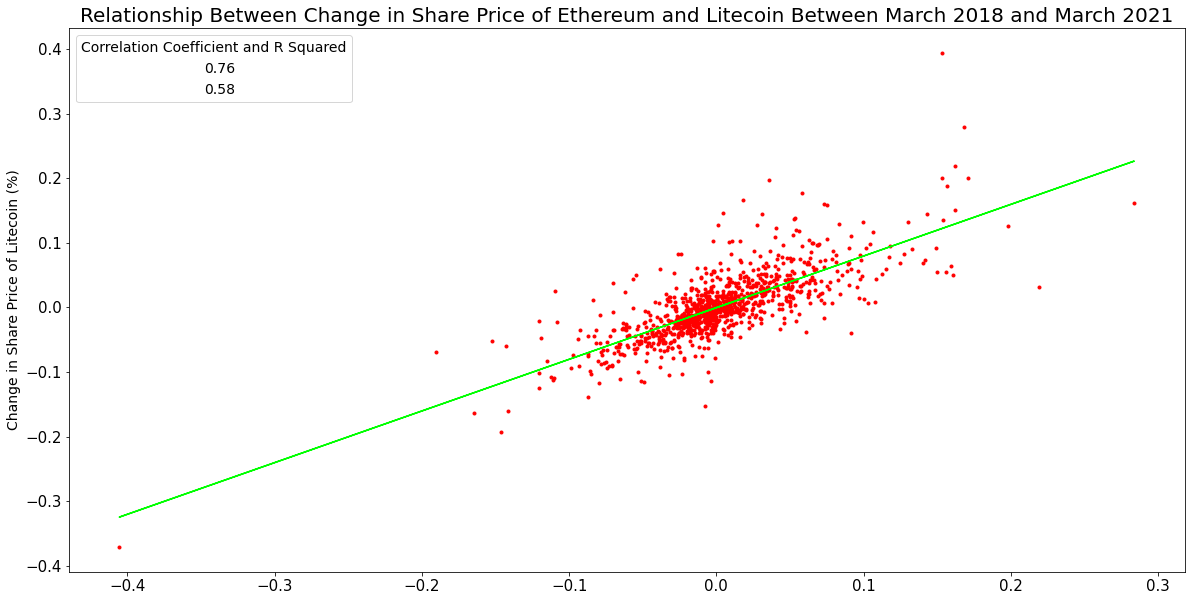

In [36]:
scatter(to_pct_change(overall_high)['ETH'], to_pct_change(overall_high)['LTC'], '.', 
        'Change in Share Price of Litecoin (%)', 
        'Relationship Between Change in Share Price of Ethereum and Litecoin Between March 2018 and March 2021')
#plt.savefig('ETH_LTC.png', bbox_inches='tight')

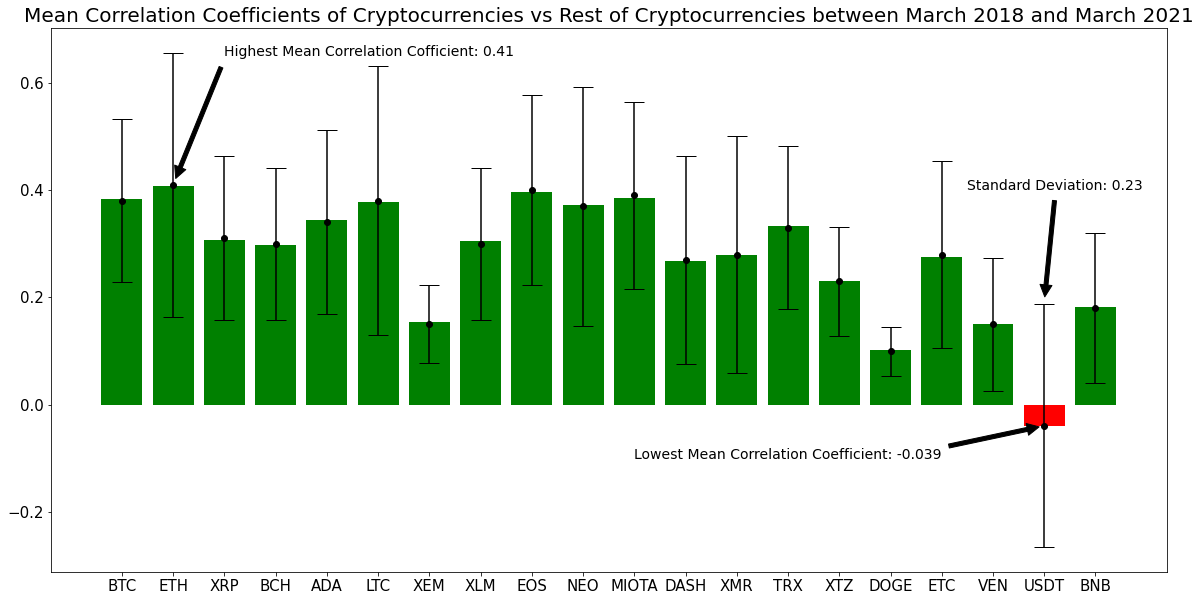

In [37]:
df = corr_coefs_df(to_pct_change(overall_high))
bars = plt.bar(df.index, fisher_z_to_r(r_to_fisher_z(corr_coefs_df(to_pct_change(overall_high))).replace(float('inf'), np.NaN).mean()), 
        color=(fisher_z_to_r(r_to_fisher_z(corr_coefs_df(to_pct_change(overall_high))).replace(float('inf'), np.NaN).mean()) > 0).map({True: 'g', False: 'r'}))
labels = [round(val, 2-int(floor(log10(abs(val))))-1) for val in list(fisher_z_to_r(r_to_fisher_z(corr_coefs_df(to_pct_change(overall_high))).replace(float('inf'), np.NaN).mean()))]
#plot errorbars representing the standard deviations setting the lower limits to true
plt.errorbar(currencies, [label for label in labels], yerr=fisher_z_to_r(r_to_fisher_z(corr_coefs_df(to_pct_change(overall_high))).replace(float('inf'), np.NaN).std()), 
    fmt='o', color='black', capsize=10)
#create list of standard deviations and use them to add labels to the errorbars using plt.annotate()
stds = [round(val, 2-int(floor(log10(abs(val))))-1) for val in list(fisher_z_to_r(r_to_fisher_z(corr_coefs_df(to_pct_change(overall_high))).replace(float('inf'), np.NaN).std()))]
plt.annotate(f'Standard Deviation: {str(stds[18])}', xy=(currencies[18], stds[18]+labels[18]), xytext=(16.5, 0.4),
        arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate(f'Lowest Mean Correlation Coefficient: {labels[18]}', xy=(18,labels[18]), xytext=(10,-0.1),
        arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate(f'Highest Mean Correlation Cofficient: {labels[1]}', xy=(1,labels[1]), xytext=(2,0.65),
            arrowprops=dict(facecolor='black',shrink=0.05))
plt.title('Mean Correlation Coefficients of Cryptocurrencies vs Rest of Cryptocurrencies between March 2018 and March 2021')
#plt.savefig('Mean_Corr_Coefs_Third_Annot.png', bbox_inches='tight')
plt.show()

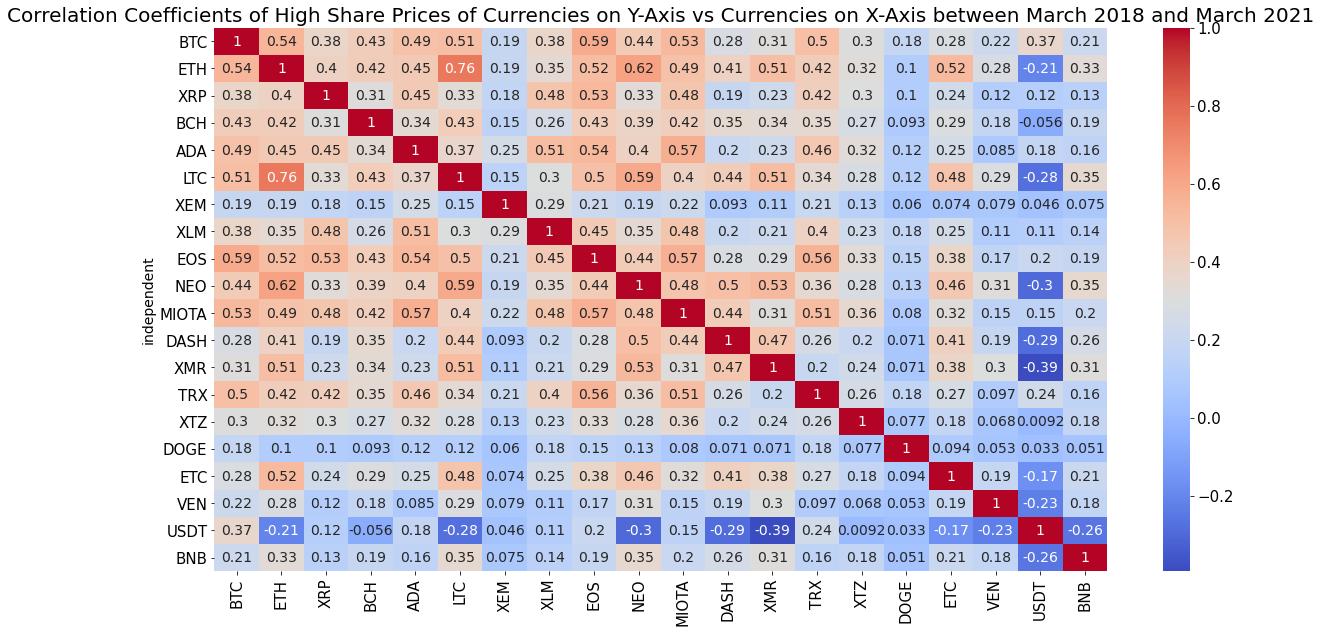

In [38]:
df = to_pct_change(overall_high)
plot_heatmap_corr_coefs(df, 
        f'Correlation Coefficients of High Share Prices of Currencies on Y-Axis vs Currencies on X-Axis between March 2018 and March 2021',
        0)
#plt.savefig('Corr_Coefs_Heatmap.png', bbox_inches='tight')

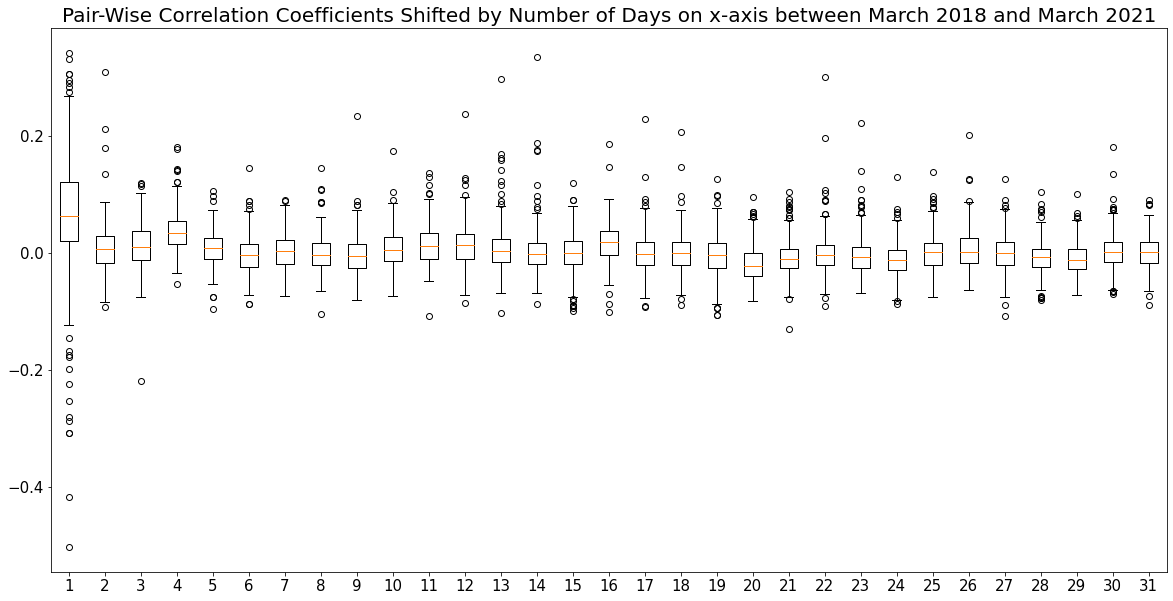

In [39]:
pairwise_corr_coefs_shifted_days = []
for days in range(1, 32):
    pairwise_corr_coefs_shifted_days.append([item for sublist in corr_coefs_days_later(to_pct_change(overall_high), days).values.tolist() for item in sublist])
plt.boxplot(pairwise_corr_coefs_shifted_days)
plt.title(f'Pair-Wise Correlation Coefficients Shifted by Number of Days on x-axis between March 2018 and March 2021')
#plt.savefig('Corr_Coefs_Box.png', bbox_inches='tight')
plt.show()

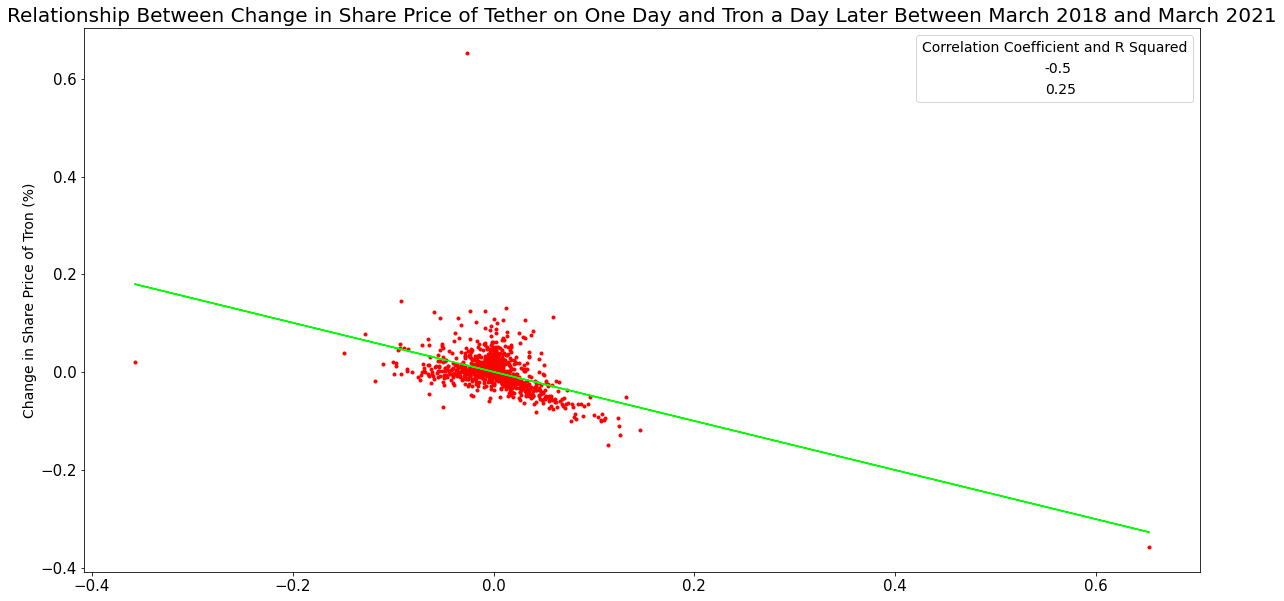

In [40]:
scatter(to_pct_change(days_later(overall_high, 'USDT', 1))['USDT'], to_pct_change(days_later(overall_high, 'USDT', 1))['TRX'], '.', 
        'Change in Share Price of Tron (%)', 
        'Relationship Between Change in Share Price of Tether on One Day and Tron a Day Later Between March 2018 and March 2021')
#plt.savefig('USDT_TRX.png', bbox_inches='tight')